Getting started code


In [2]:
!pip uninstall torch torchvision -y
!pip install torch==2.3.0 torchvision==0.18.0 --index-url https://download.pytorch.org/whl/cpu
!pip install stable-baselines3 gymnasium
!pip install swig
!pip install gymnasium[box2d]

import gymnasium as gym
import numpy as np

import os
from tqdm import tqdm

from stable_baselines3 import TD3
from stable_baselines3 import PPO
from stable_baselines3.common.noise import NormalActionNoise, VectorizedActionNoise
from stable_baselines3.common.callbacks import BaseCallback


from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv


from stable_baselines3.common.evaluation import evaluate_policy


import matplotlib.pyplot as plt
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy


from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from gymnasium.wrappers import RecordVideo

Found existing installation: torch 2.9.0+cpu
Uninstalling torch-2.9.0+cpu:
  Successfully uninstalled torch-2.9.0+cpu
Found existing installation: torchvision 0.24.0+cpu
Uninstalling torchvision-0.24.0+cpu:
  Successfully uninstalled torchvision-0.24.0+cpu
Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.4/190.4 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.9.0+cpu requires torch==2.9.0, but you have torch 2.3.0+cpu which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 11.0 MB/s eta 0:00:00
  Preparing metad

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [3]:
class SimpleWalkerWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.prev_action = np.zeros(4)

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)

        # 1. Simple Forward Reward
        # Reward speed, but only if it's actually moving forward (positive velocity)
        vel_x = obs[2]
        forward = 5.0 * max(0, vel_x)

        # 2. Simple Upright Bonus
        # Penalize the hull angle. Index 0 is hull angle (0 is perfect).
        # This keeps the robot from face-planting or leaning too far back.
        upright = -3.0 * abs(obs[0])

        # 3. Simple Smoothness Penalty
        # Penalize the difference between the current motor command and the last one.
        # This stops the "stuttering" or "skipping" behavior.
        change_in_action = np.mean(np.abs(action - self.prev_action))
        smoothness = -0.5 * change_in_action
        self.prev_action = action.copy()

        # 4. Simple Survival/Crash logic
        # If it crashes, give it a big negative sting.
        if terminated and reward <= -100:
            reward -= 50

        # Combine everything into the final reward
        total_reward = reward + forward + upright + smoothness

        return obs, total_reward, terminated, truncated, info

In [5]:


class TqdmCallback(BaseCallback):
    def __init__(self, total_timesteps):
        super().__init__()
        self.pbar = None
        self.total_timesteps = total_timesteps

    def _on_training_start(self):
        self.pbar = tqdm(total=self.total_timesteps, desc="Training")
    def _on_step(self):
        self.pbar.update(1)
        return True



    def _on_training_end(self):
        self.pbar.close()


log_dir = "walker_logs/"
video_dir = "eval_videos/"
os.makedirs(log_dir, exist_ok=True)
os.makedirs(video_dir, exist_ok=True)


def make_env():
    env = gym.make("BipedalWalker-v3")
    env = SimpleWalkerWrapper(env)
    return Monitor(env, log_dir)

train_env = DummyVecEnv([make_env])
train_env = VecNormalize(train_env, norm_obs=True, norm_reward=True)


model = PPO(
    "MlpPolicy",
    train_env,
    n_steps=2048,
    batch_size=128,
    n_epochs=10,
    gamma=0.999,
    gae_lambda=0.98,
    ent_coef=0.01,
    use_sde=True,
    sde_sample_freq=4,
    clip_range=0.2,
    verbose=1
)

total_steps = 300_000
model.learn(total_timesteps=total_steps)

model.save("walker_model_ppo")
train_env.save("vec_normalize_ppo.pkl")

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 108      |
|    ep_rew_mean     | -354     |
| time/              |          |
|    fps             | 420      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 104         |
|    ep_rew_mean          | -335        |
| time/                   |             |
|    fps                  | 460         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.018182129 |
|    clip_fraction        | 0.0714      |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.7       |
|    explained_variance   | -0.0752     |
|    learning

In [7]:


eval_env = gym.make("BipedalWalker-v3",render_mode="rgb_array")

eval_env = RecordVideo(
    eval_env,
    video_folder=video_dir,
    episode_trigger=lambda x: True,
    name_prefix="100_000_timesteps"
)

print(f"\nRecording evaluation videos to {video_dir}...")

for episode in range(3):
    obs, info = eval_env.reset()
    done = False
    while not done:
        norm_obs = train_env.normalize_obs(obs)
        action, _ = model.predict(norm_obs, deterministic=True)
        obs, reward, terminated, truncated, info = eval_env.step(action)
        done = terminated or truncated

eval_env.close()

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/eval_videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(



Recording evaluation videos to eval_videos/...


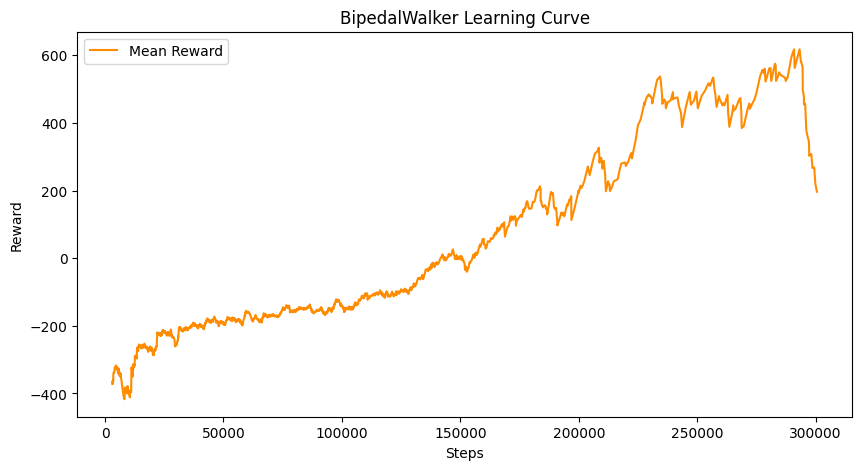

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [23]:

def moving_average(values, window):
    return np.convolve(values, np.repeat(1.0, window) / window, "valid")

x, y = ts2xy(load_results(log_dir), "timesteps")
y_mean = moving_average(y, window=25)
x_mean = x[len(x) - len(y_mean):]

plt.figure(figsize=(10, 5))
plt.plot(x_mean, y_mean, label="Mean Reward", color='darkorange')
plt.title("BipedalWalker Learning Curve")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.legend()
plt.show()

In [25]:
env_id = "BipedalWalkerHardcore-v3"

hard_env = make_vec_env(env_id, n_envs=16)
hard_env = VecNormalize.load("vec_normalize_ppo.pkl", hard_env)

hard_env.training = True
hard_env.norm_reward = False

model = PPO(
    "MlpPolicy",
    hard_env,
    n_steps=2048,
    batch_size=256,
    n_epochs=10,
    gamma=0.999,
    gae_lambda=0.98,
    ent_coef=0.01,
    use_sde=True,
    sde_sample_freq=4,
    learning_rate=3e-4,
    verbose=1
)

model.learn(
    total_timesteps=5_000_000,
    reset_num_timesteps=False
)

model.save("walker_hardcore_ppo")
hard_env.save("vec_normalize_hardcore.pkl")


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 108      |
|    ep_rew_mean     | -117     |
| time/              |          |
|    fps             | 1627     |
|    iterations      | 1        |
|    time_elapsed    | 20       |
|    total_timesteps | 32768    |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 131          |
|    ep_rew_mean          | -119         |
| time/                   |              |
|    fps                  | 1363         |
|    iterations           | 2            |
|    time_elapsed         | 48           |
|    total_timesteps      | 65536        |
| train/                  |              |
|    approx_kl            | 0.0071099885 |
|    clip_fraction        | 0.0313       |
|    clip_range           | 0.2          |
|    entropy_loss         | -12          |
|    explained_variance   | -0.000536    

In [26]:

eval_env = gym.make(env_id, hardcore=True,render_mode="rgb_array")


eval_env = RecordVideo(
    eval_env,
    video_folder=video_dir,
    episode_trigger=lambda x: True,
    name_prefix="vector_eval"
)

print(f"\nRecording evaluation videos to {video_dir}...")

for episode in range(3):
    obs, info = eval_env.reset()
    done = False
    while not done:

        norm_obs = train_env.normalize_obs(obs)
        action, _ = model.predict(norm_obs, deterministic=True)
        obs, reward, terminated, truncated, info = eval_env.step(action)
        done = terminated or truncated

eval_env.close()

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/eval_videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(



Recording evaluation videos to eval_videos/...
